In [97]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

from sklearn.utils import shuffle
from datetime import datetime
from sklearn.metrics import f1_score

In [98]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [99]:
class Tree:
    def __init__(self, word, label):
        self.left = None
        self.right = None
        self.word = word
        self.label = label


def display_tree(t, lvl=0):
    prefix = ''.join(['>']*lvl)
    if t.word is not None:
        print("%s%s %s" % (prefix, t.label, t.word))
    else:
        print("%s%s -" % (prefix, t.label))
        # if t.left is None or t.right is None:
        #     raise Exception("Tree node has no word but left and right child are None")
    if t.left:
        display_tree(t.left, lvl + 1)
    if t.right:
        display_tree(t.right, lvl + 1)


current_idx = 0
def str2tree(s, word2idx):
    # take a string that starts with ( and MAYBE ends with )
    # return the tree that it represents
    # EXAMPLE: "(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))"
    # NOTE: not every node has 2 children (possibly not correct ??)
    # NOTE: not every node has a word
    # NOTE: every node has a label
    # NOTE: labels are 0,1,2,3,4
    # NOTE: only leaf nodes have words
    # s[0] = (, s[1] = label, s[2] = space, s[3] = character or (

    # print "Input string:", s, "len:", len(s)

    global current_idx

    label = int(s[1])
    if s[3] == '(':
        t = Tree(None, label)
        # try:

        # find the string that represents left child
        # it can include trailing characters we don't need, because we'll only look up to )
        child_s = s[3:]
        t.left = str2tree(child_s, word2idx)

        # find the string that represents right child
        # can contain multiple ((( )))
        # left child is completely represented when we've closed as many as we've opened
        # we stop at 1 because the first opening paren represents the current node, not children nodes
        i = 0
        depth = 0
        for c in s:
            i += 1
            if c == '(':
                depth += 1
            elif c == ')':
                depth -= 1
                if depth == 1:
                    break
        # print "index of right child", i

        t.right = str2tree(s[i+1:], word2idx)

        # except Exception as e:
        #     print "Exception:", e
        #     print "Input string:", s
        #     raise e

        # if t.left is None or t.right is None:
        #     raise Exception("Tree node has no word but left and right child are None")
        return t
    else:
        # this has a word, so it's a leaf
        r = s.split(')', 1)[0]
        word = r[3:].lower()
        # print "word found:", word

        if word not in word2idx:
            word2idx[word] = current_idx
            current_idx += 1

        t = Tree(word2idx[word], label)
        return t


def get_ptb_data():
    # like the wikipedia dataset, I want to return 2 things:
    # word2idx mapping, sentences
    # here the sentences should be Tree objects

    word2idx = {}
    train = []
    test = []

    # train set first
    for line in open('./data/large_files/stanford_sentiment/trees/train.txt'):
        line = line.rstrip()
        if line:
            t = str2tree(line, word2idx)
            # if t.word is None and t.left is None and t.right is None:
            #     print "sentence:", line
            # display_tree(t)
            # print ""
            train.append(t)
            # break

    # test set
    for line in open('./data/large_files/stanford_sentiment/trees/test.txt'):
        line = line.rstrip()
        if line:
            t = str2tree(line, word2idx)
            test.append(t)
    return train, test, word2idx

In [100]:
class RecursiveNN:
    def __init__(self, V, D, K):
        self.V = V
        self.D = D
        self.K = K

    def fit(self, trees, tests, learning_rate=1e-3, mu=0.5, reg=1e-2, eps=1e-2, epochs=20, activation=T.tanh, train_inner_nodes=False):
        D = self.D
        V = self.V
        K = self.K
        self.f = activation
        N = len(trees)

        print("learning rate:", learning_rate)
        print("regularization:", reg)
        print("mu:", mu)
        print("eps:", eps)
        print("dim:", D)
        print("epochs:", epochs)
    
        We = init_weight(V, D)
        W11 = np.random.randn(D, D, D) / np.sqrt(3*D)
        W22 = np.random.randn(D, D, D) / np.sqrt(3*D)
        W12 = np.random.randn(D, D, D) / np.sqrt(3*D)
        W1 = init_weight(D, D)
        W2 = init_weight(D, D)
        bh = np.zeros(D)
        Wo = init_weight(D, K)
        bo = np.zeros(K)

        self.We = theano.shared(We)
        self.W11 = theano.shared(W11)
        self.W22 = theano.shared(W22)
        self.W12 = theano.shared(W12)
        self.W1 = theano.shared(W1)
        self.W2 = theano.shared(W2)
        self.bh = theano.shared(bh)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.We, self.W11, self.W22, self.W12, self.W1, self.W2, self.bh, self.Wo, self.bo]

        words = T.ivector('words')
        left_children = T.ivector('left_children')
        right_children = T.ivector('right_children')
        labels = T.ivector('labels')

        def recurrence(n, hiddens, words, left, right):
            w = words[n]
            # any non-word will have index -1
            hiddens = T.switch(
                T.ge(w, 0),
                T.set_subtensor(hiddens[n], self.We[w]),
                T.set_subtensor(hiddens[n],
                    self.f(
                        hiddens[left[n]].dot(self.W11).dot(hiddens[left[n]]) +
                        hiddens[right[n]].dot(self.W22).dot(hiddens[right[n]]) +
                        hiddens[left[n]].dot(self.W12).dot(hiddens[right[n]]) +
                        hiddens[left[n]].dot(self.W1) +
                        hiddens[right[n]].dot(self.W2) +
                        self.bh
                    )
                )
            )
            return hiddens

        hiddens = T.zeros((words.shape[0], D))

        h, _ = theano.scan(
            fn=recurrence,
            outputs_info=[hiddens],
            n_steps=words.shape[0],
            sequences=T.arange(words.shape[0]),
            non_sequences=[words, left_children, right_children],
        )

        py_x = T.nnet.softmax(h[-1].dot(self.Wo) + self.bo)

        prediction = T.argmax(py_x, axis=1)
        
        rcost = reg*T.mean([(p*p).sum() for p in self.params])
        if train_inner_nodes:
            cost = -T.mean(T.log(py_x[T.arange(labels.shape[0]), labels])) + rcost
        else:
            cost = -T.mean(T.log(py_x[-1, labels[-1]])) + rcost
        grads = T.grad(cost, self.params)
        # dparams = [theano.shared(p.get_value()*0) for p in self.params]
        cache = [theano.shared(p.get_value()*0) for p in self.params]

        # momentum
        # updates = [
        #     (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        # ] + [
        #     (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        # ]
        updates = [
            (c, c + g*g) for c, g in zip(cache, grads)
        ] + [
            (p, p - learning_rate*g / T.sqrt(c + eps)) for p, c, g in zip(self.params, cache, grads)
        ]

        self.cost_predict_op = theano.function(
            inputs=[words, left_children, right_children, labels],
            outputs=[cost, prediction],
            allow_input_downcast=True,
        )

        self.train_op = theano.function(
            inputs=[words, left_children, right_children, labels],
            outputs=[cost, prediction],
            updates=updates
        )

        costs = []
        sequence_indexes = range(N)
        if train_inner_nodes:
            n_total = sum(len(words) for words, _, _, _ in trees)
        else:
            n_total = N
        for i in range(epochs):
            t0 = datetime.now()
            sequence_indexes = shuffle(sequence_indexes)
            n_correct = 0
            cost = 0
            it = 0
            for j in sequence_indexes:
                words, left, right, lab = trees[j]
                c, p = self.train_op(words, left, right, lab)
                if np.isnan(c):
                    print("Cost is nan! Let's stop here. Why don't you try decreasing the learning rate?")
                    exit()
                cost += c
                if train_inner_nodes:
                    n_correct += np.sum(p == lab)
                else:
                    n_correct += (p[-1] == lab[-1])
                it += 1
                if it % 1 == 0:
                    sys.stdout.write("j/N: %d/%d correct rate so far: %f, cost so far: %f\r" % (it, N, float(n_correct)/n_total, cost))
                    sys.stdout.flush()
            print("i:", i, "cost:", cost, "correct rate:", (float(n_correct)/n_total), "time for epoch:", (datetime.now() - t0))
            print("test accuracy:", self.score(tests))
            
            costs.append(cost)

        plt.plot(costs)
        plt.show()

    def score(self, trees):
        n_total = len(trees)
        n_correct = 0
        for words, left, right, lab in trees:
            _, p = self.cost_predict_op(words, left, right, lab)
            n_correct += (p[-1] == lab[-1])
        return float(n_correct) / n_total

    def f1_score(self, trees):
        Y = []
        P = []
        for words, left, right, lab in trees:
            _, p = self.cost_predict_op(words, left, right, lab)
            Y.append(lab[-1])
            P.append(p[-1])
        return f1_score(Y, P, average=None).mean()


def add_idx_to_tree(tree, current_idx):
    # post-order labeling of tree nodes
    if tree is None:
        return current_idx
    current_idx = add_idx_to_tree(tree.left, current_idx)
    current_idx = add_idx_to_tree(tree.right, current_idx)
    tree.idx = current_idx
    current_idx += 1
    return current_idx


def tree2list(tree, parent_idx, is_binary=False):
    if tree is None:
        return [], [], [], []

    words_left, left_child_left, right_child_left, labels_left = tree2list(tree.left, tree.idx, is_binary)
    words_right, left_child_right, right_child_right, labels_right = tree2list(tree.right, tree.idx, is_binary)

    if tree.word is None:
        w = -1
        left = tree.left.idx
        right = tree.right.idx
    else:
        w = tree.word
        left = -1
        right = -1

    words = words_left + words_right + [w]
    left_child = left_child_left + left_child_right + [left]
    right_child = right_child_left + right_child_right + [right]

    if is_binary:
        if tree.label > 2:
            label = 1
        elif tree.label < 2:
            label = 0
        else:
            label = -1 # we will eventually filter these out
    else:
        label = tree.label
    labels = labels_left + labels_right + [label]

    return words, left_child, right_child, labels


def main(is_binary=True, learning_rate=1e-3, reg=1e-2, D=10, epochs=30):
    train, test, word2idx = get_ptb_data()

    for t in train:
        add_idx_to_tree(t, 0)
    train = [tree2list(t, -1, is_binary) for t in train]
    if is_binary:
        train = [t for t in train if t[3][-1] >= 0] # for filtering binary labels

    for t in test:
        add_idx_to_tree(t, 0)
    test = [tree2list(t, -1, is_binary) for t in test]
    if is_binary:
        test = [t for t in test if t[3][-1] >= 0] # for filtering binary labels

    train = shuffle(train)
#     train = train[:5000]
    # n_pos = sum(t[3][-1] for t in train)
    # print "n_pos train:", n_pos
    test = shuffle(test)
#     test = test[:1000]
    # n_pos = sum(t[3][-1] for t in test)
    # print "n_pos test:", n_pos

    V = len(word2idx)
    print("vocab size:", V)
#     D = 20
    K = 2 if is_binary else 5

    model = RecursiveNN(V, D, K)
    model.fit(train, test[:200], learning_rate=learning_rate, reg=reg, epochs=epochs)
    print("train accuracy:", model.score(train))
    print("test accuracy:", model.score(test))
    print("train f1:", model.f1_score(train))
    print("test f1:", model.f1_score(test))

In [20]:
main()

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 10
epochs: 30


KeyboardInterrupt: 

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
epochs: 20
i: 0 cost: 5656.89129766 correct rate: 0.5192 time for epoch: 0:24:34.324584
i: 1 cost: 5238.96118646 correct rate: 0.5392 time for epoch: 0:25:56.164000
i: 2 cost: 4915.33974476 correct rate: 0.556 time for epoch: 0:26:51.524128
i: 3 cost: 4658.58585352 correct rate: 0.563 time for epoch: 0:26:15.986952
i: 4 cost: 4452.30910999 correct rate: 0.569 time for epoch: 0:22:49.850555
i: 5 cost: 4285.08074052 correct rate: 0.5708 time for epoch: 0:15:31.024638
i: 6 cost: 4148.55771176 correct rate: 0.5724 time for epoch: 0:15:35.512787
i: 7 cost: 4036.4217526 correct rate: 0.5778 time for epoch: 0:14:29.747316
i: 8 cost: 3943.81866816 correct rate: 0.5786 time for epoch: 0:15:03.993362
i: 9 cost: 3866.88634854 correct rate: 0.581 time for epoch: 0:16:25.069873
i: 10 cost: 3802.58804799 correct rate: 0.5846 time for epoch: 0:15:26.889256
i: 11 cost: 3748.43372422 correct rate: 0.5864 time for epoch: 0:15:

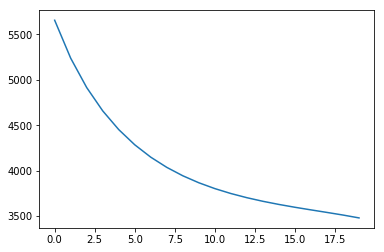

train accuracy: 0.6278
test accuracy: 0.541
train f1: 0.610250010063
test f1: 0.5247340219


In [21]:
main()

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
epochs: 30
i: 0 cost: 5682.52570901 correct rate: 0.5242 time for epoch: 0:13:09.725612
i: 1 cost: 5266.64537063 correct rate: 0.5246 time for epoch: 0:15:09.559144
i: 2 cost: 4945.09294923 correct rate: 0.5254 time for epoch: 0:13:28.570812
i: 3 cost: 4689.17336893 correct rate: 0.5256 time for epoch: 0:12:23.821843
i: 4 cost: 4482.47563313 correct rate: 0.5264 time for epoch: 0:12:10.353844
i: 5 cost: 4313.35033073 correct rate: 0.5274 time for epoch: 0:12:21.583955
i: 6 cost: 4172.50045971 correct rate: 0.5284 time for epoch: 0:13:07.453650
i: 7 cost: 4051.1719397 correct rate: 0.533 time for epoch: 0:13:15.305788
i: 8 cost: 3935.77011717 correct rate: 0.5394 time for epoch: 0:12:45.451379
i: 9 cost: 3794.09758111 correct rate: 0.5546 time for epoch: 0:13:35.300900
i: 10 cost: 3582.4547334 correct rate: 0.6018 time for epoch: 0:13:18.077111
i: 11 cost: 3275.02690724 correct rate: 0.7016 time for epoch: 0:1

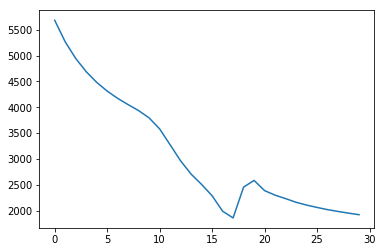

train accuracy: 0.9404
test accuracy: 0.709
train f1: 0.940383173747
test f1: 0.708992724818


In [28]:
# using 5000 data to train
main()

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
epochs: 30
i: 0 cost: 7797.02434671 correct rate: 0.5215317919075144 time for epoch: 0:17:28.485722
i: 1 cost: 7050.10760411 correct rate: 0.5219653179190752 time for epoch: 0:17:25.569553
i: 2 cost: 6516.7543784 correct rate: 0.5229768786127168 time for epoch: 0:16:45.542161
i: 3 cost: 6123.5199561 correct rate: 0.5280346820809249 time for epoch: 0:16:53.689929
i: 4 cost: 5828.61541549 correct rate: 0.5290462427745665 time for epoch: 0:16:49.699792
i: 5 cost: 5604.80122906 te so far: 0.531503, cost so far: 5604.801229correct rate: 0.5315028901734105 time for epoch: 0:16:40.213634
i: 6 cost: 5433.34274334 correct rate: 0.5356936416184971 time for epoch: 0:20:06.317510
i: 7 cost: 5300.94034456 correct rate: 0.5416184971098266 time for epoch: 0:18:13.396017
i: 8 cost: 5197.92063682 correct rate: 0.5492774566473988 time for epoch: 0:19:55.604520
i: 9 cost: 5117.12328643 correct rate: 0.5562138728323699 time for 

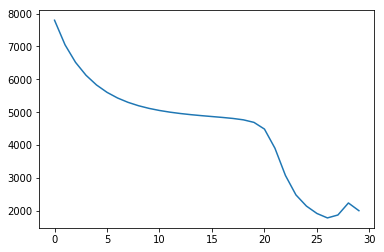

train accuracy: 0.940606936416185
test accuracy: 0.5299286106534871
train f1: 0.940467417805
test f1: 0.528950014989


In [35]:
# use all 6920 data to train
main()

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 10
epochs: 30
i: 0 cost: 5620.38366708 correct rate: 0.5270231213872832 time for epoch: 0:07:08.160768
i: 1 cost: 5434.29366643 correct rate: 0.5485549132947977 time for epoch: 0:08:21.278778
i: 2 cost: 5308.39604195 correct rate: 0.551878612716763 time for epoch: 0:08:23.531452
i: 3 cost: 5218.20754612 correct rate: 0.5546242774566474 time for epoch: 0:08:05.670622
i: 4 cost: 5151.64277712 correct rate: 0.5546242774566474 time for epoch: 0:07:47.220601
i: 5 cost: 5100.90839223 correct rate: 0.555635838150289 time for epoch: 0:08:21.323312
i: 6 cost: 5060.99409644 correct rate: 0.5591040462427745 time for epoch: 0:08:27.869376
i: 7 cost: 5028.31615758 correct rate: 0.5611271676300578 time for epoch: 0:08:36.349116
i: 8 cost: 5000.2023486 correct rate: 0.5624277456647399 time for epoch: 0:08:53.717342
i: 9 cost: 4974.4468432 correct rate: 0.5651734104046243 time for epoch: 0:09:33.454156
i: 10 cost: 4949.

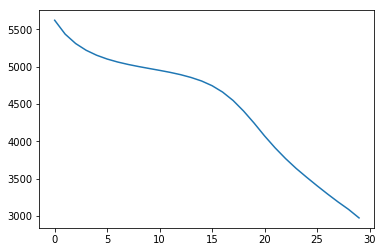

train accuracy: 0.9216763005780347
test accuracy: 0.7358594179022515
train f1: 0.921605473354
test f1: 0.734243419885


In [10]:
main(D=10)

vocab size: 18647
learning rate: 0.01
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 10
epochs: 20
i: 0 cost: 5148.55779181 correct rate: 0.5403179190751445 time for epoch: 0:08:26.131266
i: 1 cost: 4721.59131886 correct rate: 0.7245664739884393 time for epoch: 0:08:11.278593
i: 2 cost: 4166.21660797 correct rate: 0.8803468208092485 time for epoch: 0:08:13.512719
i:N: 6920/6920 correct rate so far: 0.951012, cost so far: 3665.637231 3 cost: 3665.63723133 correct rate: 0.9510115606936416 time for epoch: 0:08:20.853061
i: 4 cost: 3354.74392395 correct rate: 0.9739884393063584 time for epoch: 0:08:16.486011
i: 5 cost: 3215.00357899 correct rate: 0.9794797687861272 time for epoch: 0:08:49.317367
i: 6 cost: 3166.34854074 correct rate: 0.9845375722543352 time for epoch: 0:08:23.882065
i: 7 cost: 3220.4072465 correct rate: 0.9877167630057804 time for epoch: 0:07:48.141319
i: 8 cost: 3468.92808642 correct rate: 0.9884393063583815 time for epoch: 0:08:36.920878
i: 9 cost: 3740.36815595 correct rat

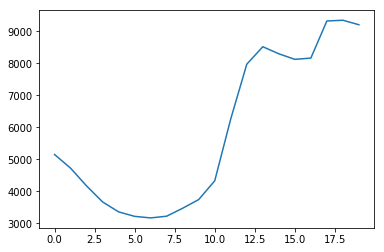

train accuracy: 0.9956647398843931
test accuracy: 0.7386051619989017
train f1: 0.995657112733
test f1: 0.738508562768


In [21]:
main(learning_rate=1e-2, D=10, epochs=20)

vocab size: 18647
learning rate: 0.01
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 20
epochs: 20
i: 0 cost: 5915.82258729 correct rate: 0.5385838150289017 time for epoch: 0:17:53.985426
i: 1 cost: 4868.66604139 correct rate: 0.5955202312138729 time for epoch: 0:18:02.182446
i: 2 cost: 4948.88601332 correct rate: 0.7183526011560694 time for epoch: 0:19:14.418587
i: 3 cost: 3878.76695988 correct rate: 0.9053468208092486 time for epoch: 0:19:16.298654
i: 4 cost: 3315.73680976 correct rate: 0.9715317919075145 time for epoch: 0:18:04.723536
i: 5 cost: 2896.78889446 correct rate: 0.9858381502890173 time for epoch: 0:17:29.619650
i: 6 cost: 2943.04351299 correct rate: 0.9894508670520231 time for epoch: 0:17:29.664866
i: 7 cost: 3062.08296851 correct rate: 0.9865606936416185 time for epoch: 0:19:25.731006
i: 8 cost: 3329.61396027 correct rate: 0.9901734104046243 time for epoch: 0:21:15.755770
i: 9 cost: 3357.164197 correct rate: 0.994364161849711 time for epoch: 0:20:12.116386
i: 10 cost: 3344.

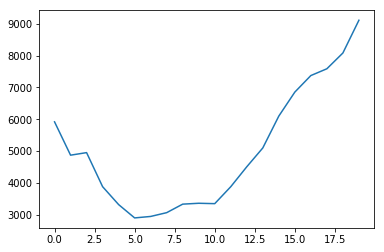

train accuracy: 0.9950867052023121
test accuracy: 0.7105985722130698
train f1: 0.995078415682
test f1: 0.710597175836


In [26]:
main(learning_rate=1e-2, D=20, epochs=20)

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 6
epochs: 20
i: 0 cost: 5155.77308498 correct rate: 0.5213872832369942 time for epoch: 0:05:32.789834
i: 1 cost: 5078.05633348 correct rate: 0.5290462427745665 time for epoch: 0:05:38.657878
i: 2 cost: 5034.37900763 correct rate: 0.5345375722543353 time for epoch: 0:10:14.567794
i: 3 cost: 4997.44724167 correct rate: 0.5447976878612717 time for epoch: 0:05:39.650509
i: 4 cost: 4962.76765884 correct rate: 0.5534682080924855 time for epoch: 0:05:02.877293
i: 5 cost: 4926.84925974 correct rate: 0.5630057803468208 time for epoch: 0:04:56.480190
i: 6 cost: 4885.92912136 correct rate: 0.5804913294797688 time for epoch: 0:05:37.059742
i: 7 cost: 4834.00715249 correct rate: 0.5969653179190751 time for epoch: 0:06:20.018657
i: 8 cost: 4763.11607442 correct rate: 0.6091040462427746 time for epoch: 0:05:13.017458
i: 9 cost: 4660.78717429 correct rate: 0.6476878612716763 time for epoch: 0:06:35.116082
i: 10 cost: 45

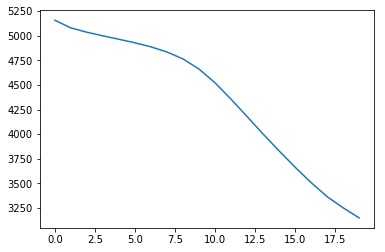

train accuracy: 0.9143063583815029
test accuracy: 0.7331136738056013
train f1: 0.914301331327
test f1: 0.732660185306


In [31]:
main(learning_rate=1e-3, D=6, epochs=20)

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 6
epochs: 25
i: 0 cost: 5138.37755055 correct rate: 0.5216763005780347 time for epoch: 0:06:03.344651
i: 1 cost: 5062.37069039 correct rate:521676, cost so far: 5062.370690 0.5216763005780347 time for epoch: 0:05:24.480114
i: 2 cost: 5010.28557295 correct rate: 0.5218208092485549 time for epoch: 0:05:22.514817
i: 3 cost: 4971.61053554 correct rate: 0.5218208092485549 time for epoch: 0:05:21.989503
i: 4 6920/6920 correct rate so far: 0.521821, cost so far: 4941.865436 cost: 4941.86543567 correct rate: 0.5218208092485549 time for epoch: 0:05:20.373974
i: 5 cost: 4918.42606368 correct rate: 0.5219653179190752 time for epoch: 0:05:18.850302
i: 6 cost: 4899.58168203 correct rate: 0.5219653179190752 time for epoch: 0:05:22.813566
i: 7 cost: 4884.1599628 correct rate: 0.522543352601156 time for epoch: 0:05:22.564196
i: 8 cost:6920 correct rate so far: 0.522688, cost so far: 4871.330898 4871.33089781 correct rat

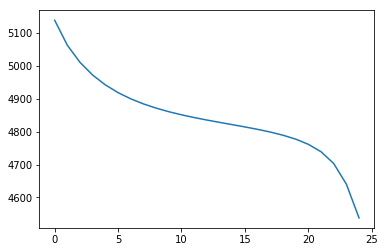

train accuracy: 0.6445086705202312
test accuracy: 0.5447556287753982
train f1: 0.596907674354
test f1: 0.487214927201


In [36]:
main(learning_rate=1e-3, D=6, epochs=25)

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 6
epochs: 25
i: 0 cost: 5130.56996178 correct rate: 0.5179190751445086 time for epoch: 0:05:39.602014
i: 1 cost: 5049.51390457 correct rate: 0.5541907514450867 time for epoch: 0:06:44.488128
i: 2 cost: 4996.49695831 correct rate: 0.5508670520231214 time for epoch: 0:05:47.437748
i: 3 cost: 4957.31588536 correct rate: 0.5491329479768786 time for epoch: 0:05:42.350673
i: 4 cost: 4927.17103368 correct rate: 0.5523121387283237 time for epoch: 0:05:20.950873
i: 5 cost: 4903.33439416 correct rate: 0.5550578034682081 time for epoch: 0:04:44.210203
i: 6 cost: 4884.06734995 correct rate: 0.559971098265896 time for epoch: 0:05:29.818327
i: 7 cost: 4868.16577722 correct rate: 0.5637283236994219 time for epoch: 0:06:00.195406
i: 8 cost: 4854.7638145 correct rate: 0.5666184971098266 : 4854.763814time for epoch: 0:05:52.426308
i: 9 cost: 4843.23620995 correct rate: 0.5700867052023122 time for epoch: 0:06:43.234958
i: 

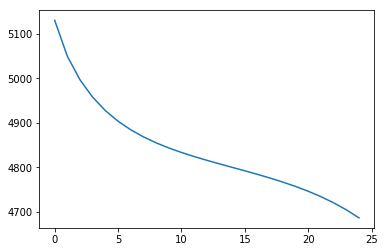

train accuracy: 0.6216763005780347
test accuracy: 0.5227896760021966
train f1: 0.594935427333
test f1: 0.491457986327


In [15]:
main(learning_rate=1e-3, D=6, epochs=25)

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 10
epochs: 25
i: 0 cost: 5630.48668585 correct rate: 0.5265895953757226 time for epoch: 0:08:55.537699
test accuracy: 0.505
i: 1 cost: 5432.76103006 correct rate: 0.5377167630057803 time for epoch: 0:07:56.082338
test accuracy: 0.51
i: 2 cost:6920 correct rate so far: 0.539595, cost so far: 5296.277181 5296.2771808 correct rate: 0.5395953757225433 time for epoch: 0:08:31.500939
test accuracy: 0.505
i: 3 cost: 5196.10410165 correct rate: 0.5421965317919075 time for epoch: 0:07:51.053959
test accuracy: 0.505
i: 4 cost: 5120.47772047 correct rate: 0.5442196531791907 time for epoch: 0:07:25.935803
test accuracy: 0.5
i: 5 cost: 5062.12292736 correct rate: 0.5455202312138728 time for epoch: 0:07:15.436522
test accuracy: 0.505
i: 6 cost: 5016.15492042 correct rate: 0.5478323699421965 time for epoch: 0:07:50.944685
test accuracy: 0.52
i: 7 cost: 4979.13672416 correct rate: 0.5501445086705202 time for epoch: 0:10

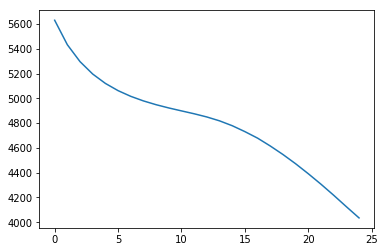

train accuracy: 0.7355491329479769
test accuracy: 0.6584294343767161
train f1: 0.725997733828
test f1: 0.645092861136


In [61]:
main(learning_rate=0.001, reg=0.01, D=10, epochs=25)

vocab size: 18647
learning rate: 0.001
regularization: 0.01
mu: 0.5
eps: 0.01
dim: 8
epochs: 35
i: 0 cost: 5353.39085885 correct rate: 0.5190751445086705 time for epoch: 0:06:10.150319
test accuracy: 0.485
i: 1 cost: 5224.42937496 correct rate: 0.5219653179190752 time for epoch: 0:06:50.516661
test accuracy: 0.48
i: 2 cost: 5134.91672533 correct rate: 0.5218208092485549 time for epoch: 0:06:38.323860
test accuracy: 0.48
i: 3 cost: 5068.93398898 correct rate: 0.5218208092485549 time for epoch: 0:07:19.705021
test accuracy: 0.48
i: 4 cost: 5018.90571983 correct rate: 0.5218208092485549 time for epoch: 0:06:16.030510
test accuracy: 0.48
i: 5 cost: 4980.24056337 correct rate: 0.5218208092485549 time for epoch: 0:06:33.064104
test accuracy: 0.48
i: 6 cost: 4949.92241567 correct rate: 0.5218208092485549 time for epoch: 0:07:24.590049
test accuracy: 0.48
i: 7 cost: 4925.86229047 correct rate: 0.5218208092485549 time for epoch: 0:06:23.899500
test accuracy: 0.48
i: 8 cost: 4906.57341321 correc

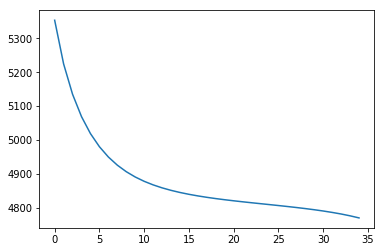

train accuracy: 0.5501445086705202
test accuracy: 0.5090609555189456
train f1: 0.432849471225
test f1: 0.392011622175


In [101]:
main(learning_rate=0.001, reg=0.01, D=10, epochs=35)